### Introduction 
The following code used machine learning to figure out 1) the best model to predict the synthesis outcome (fail or success) of any input oligonucleotides, 2) the main features responsible for the failure of the synthesis of the input oligonucleotides.

The data contains 17.5% failied and 82.5% succeeded oligonucleotides and their physical parameters. From statistical analysis, length, miminum free energy, paired group and paired GC group are correlated with the failed synthesis. Please read the Statistical_Analysis_of_All_Data.ipynb file first to get more details of the data.


### Data Import and Feature Engineering
First, let's import python modules including csv, numpy, pandas and scikit learn (for machine learning) used for this project.

In [1]:
import csv as csv
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
%matplotlib inline

Let's first import data and do some data cleaning and feature engineering. Please refer to Statistical_Analysis_of_All_Data.ipynb file for detailed explaination.  

In [2]:
train = pd.read_csv('base_data.csv', header = 0)
train['GC'] = train['unpairedGC'] + train['pairedGC']
train['GC_norm'] = train['GC']/train['length']
train['mfe_norm'] = train['mfe']/train['length']
train['paired_norm'] = train['paired']/train['length']
train['pairedGC_norm'] = train['pairedGC']/train['length']
train['hairpin_norm'] = train['hairpin']/train['length']
train['interior_loop'] = train['interior_loop']/train['length']
train['bulge_norm'] = train['bulge']/train['length']
train['multi_loop_norm'] = train['multi_loop']/train['length']
train['external_norm'] = train['external']/train['length']
Y = train['success']
train = train.drop(['rec','mfe', 'stack', 'unpaired', 'unpairedGC', 'hairpin', 'interior_loop', 'bulge', 'multi_loop',
                    'external', 'GC', 'paired', 'pairedGC', 'success'], axis=1)

train.head(5)

,length,GC_norm,mfe_norm,paired_norm,pairedGC_norm,hairpin_norm,bulge_norm,multi_loop_norm,external_norm
0,562,0.521352,-0.310498,0.629893,0.384342,0.128114,0.023132,0.083630,0.005338
1,528,0.494318,-0.300000,0.632576,0.352273,0.132576,0.022727,0.096591,0.043561
2,529,0.506616,-0.333459,0.608696,0.349716,0.179584,0.037807,0.068053,0.018904
3,664,0.493976,-0.297139,0.629518,0.368976,0.115964,0.028614,0.097892,0.012048
4,722,0.468144,-0.262188,0.573407,0.332410,0.098338,0.037396,0.090028,0.041551


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 9 columns):
length             2880 non-null int64
GC_norm            2880 non-null float64
mfe_norm           2880 non-null float64
paired_norm        2880 non-null float64
pairedGC_norm      2880 non-null float64
hairpin_norm       2880 non-null float64
bulge_norm         2880 non-null float64
multi_loop_norm    2880 non-null float64
external_norm      2880 non-null float64
dtypes: float64(8), int64(1)
memory usage: 202.6 KB


### Building single models

First, let's split the data into train and test dataset.
Ideally we would have two data sets: train and test dataset. Then we split train dataset into two parts, one for training the model, the other one for validate the model to avoid overfitting.  Here we only have one data set and split it into train and test data set. Each model is validated using cross validation. 

In [4]:
# change dataframe into numpy array
X = train.values

# use 80% data for training models and 20% for cross validation
test_size = 0.20

# fix random_state to make the results reproducible
seed = 6

# randomly split data into train and test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size 
                                               = test_size, random_state = seed)

Let's then building models. Given that it is a classification problem and the data has labels, we'll try supervised machine learning methods such as logistic regression, linear discriminant analysis, decision tree, Gaussian Naive Bayes, and support vector machine. We will also try unsupervised machine learning method such as K nearest neighbor.

In [5]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

Evaluate each model. Here we will use ten-fold cross validation with accuracy as the evaluation metric.

In [6]:
results = []
names = []

# set evaluation metric as accuracy
scoring = 'accuracy'

# use 10-fold cross validation
num_folds = 10

# fix random state
seed = 7

def run_model(modelname):
    for name, model in modelname:
    
        # KFold returns the training set indices and testing set indices for that splitting
        kfold = KFold(n_splits = num_folds, random_state = seed)
    
        # cross_val_score returns an array of scores of the estimator for each run of the cross validation. It is a 10*1 array here.
        cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = 'accuracy')
    
        # put all cv_results in a list named results and names in a list named names
        results.append(cv_results)
        names.append(name)
    
        # output model name, mean and standard deviation of accuracy of the cross validation for each model
        msg = "%s: %f (%f)" %(name, cv_results.mean(), cv_results.std())
        print(msg)

run_model(models)

LR: 0.825936 (0.027286)
LDA: 0.847632 (0.028897)
KNN: 0.818146 (0.032452)
CART: 0.769977 (0.025938)
NB: 0.814643 (0.030258)
SVM: 0.838952 (0.028845)


Let's visualize the results of these algorithms.

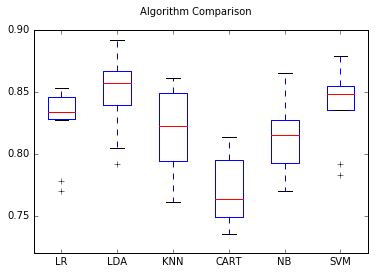

In [7]:
# making plots using matplotlib

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We can tell that linear discriminant analysis (LDA) and support vector machine (SVM) gives the highest accuracy. Logistic 
regression gives slightly lower accuracy but also much lower standard deviation. Decision tree performs really bad here.

### Standardize Dataset
It is known that many machine learning algorithms don't perform well if the individual features look more or less like Guassian 
distribution. Therefore, let's standardize the dataset by subtracting the mean and scaling to unit variance (x --> (x-u)/sigma). Hopefully the algorithms perform better.

In [8]:
pipelines = []

# Each Pipeline contains one or many transforms and a final estimator in the format of (name, operation).
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []

run_model(pipelines)

ScaledLR: 0.836350 (0.028877)
ScaledLDA: 0.847632 (0.028897)
ScaledKNN: 0.833301 (0.030390)
ScaledCART: 0.766497 (0.030351)
ScaledNB: 0.813776 (0.030776)
ScaledSVM: 0.855016 (0.028724)


Similarily, let's visualize the results of the algorithms

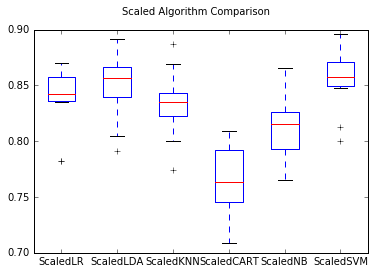

In [9]:
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)

# input of boxplot is results, which is a list of 10*1 arrays containing accuracy. 
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


Standardizing the data improved the accuracy of all algorithms. The general trend is still the same: linear discriminant analysis (LDA) and support vector machine (SVM) gives the highest accuracy. Let's further tuning the parameters of these two algorithms to achieve higher accuracy. 

We'll start with scaled LDA.

In [10]:
# standardize X_train
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# scan three different solver value, try to find the optimum value
solver_value = ['svd', 'lsqr', 'eigen']
param_grid = dict(solver = solver_value)

# define model
model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits = num_folds, random_state = seed)

# grid search different solver value
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# output grid search results (mean, standard deviation)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("results from scaled LDA are %f (%f) with: %r" % (mean, stdev, params))

Best: 0.847656 using {'solver': 'svd'}
results from scaled LDA are 0.847656 (0.028888) with: ({'solver': 'svd'}, {'solver': 'lsqr'}, {'solver': 'eigen'})
results from scaled LDA are 0.847656 (0.028888) with: ({'solver': 'svd'}, {'solver': 'lsqr'}, {'solver': 'eigen'})
results from scaled LDA are 0.825955 (0.027269) with: ({'solver': 'svd'}, {'solver': 'lsqr'}, {'solver': 'eigen'})


The accuracy of scaled LDA improved from 0.847632 to 0.847656. Not a lot but still worth the effort.

Similarily, let's tune scaled SVM.

In [11]:
# scan c values (c is the penalty parameter, default value is 1.0) and kernel type
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel= kernel_values)

# define model
model = SVC()
kfold = KFold(n_splits = num_folds, random_state = seed)

# grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

# output grid search result
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("results from scaled SVM are %f (%f) with: %r" % (mean, stdev, param))

Best: 0.855035 using {'C': 0.3, 'kernel': 'poly'}
results from scaled SVM are 0.825955 (0.027269) with: {'C': 0.1, 'kernel': 'linear'}
results from scaled SVM are 0.854167 (0.030255) with: {'C': 0.1, 'kernel': 'poly'}
results from scaled SVM are 0.845920 (0.028381) with: {'C': 0.1, 'kernel': 'rbf'}
results from scaled SVM are 0.813802 (0.034130) with: {'C': 0.1, 'kernel': 'sigmoid'}
results from scaled SVM are 0.825955 (0.027269) with: {'C': 0.3, 'kernel': 'linear'}
results from scaled SVM are 0.855035 (0.029435) with: {'C': 0.3, 'kernel': 'poly'}
results from scaled SVM are 0.853733 (0.030178) with: {'C': 0.3, 'kernel': 'rbf'}
results from scaled SVM are 0.767795 (0.032777) with: {'C': 0.3, 'kernel': 'sigmoid'}
results from scaled SVM are 0.825955 (0.027269) with: {'C': 0.5, 'kernel': 'linear'}
results from scaled SVM are 0.855035 (0.029435) with: {'C': 0.5, 'kernel': 'poly'}
results from scaled SVM are 0.854167 (0.030193) with: {'C': 0.5, 'kernel': 'rbf'}
results from scaled SVM are 

The accuracy of scaled LDA improved from 0.855016 to 0.855035.

### Ensemble Method
Ensemble learning helps improve machine learning results by combining several models. Let's check how ensemble learning improves
the accuracy of these algorithms.

The ensemble methods we use are AdaBoosting, gradient boosting, random forest and extra trees.

In [12]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []

run_model(ensembles)

AB: 0.848080 (0.030391)
GBM: 0.860222 (0.026446)
RF: 0.849366 (0.024629)
ET: 0.848965 (0.019929)


Visualize results as follows:

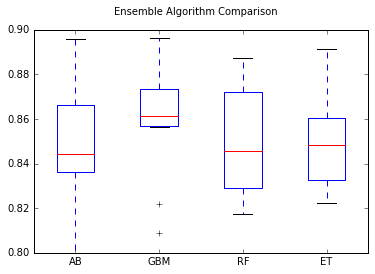

In [13]:
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Gradient boosting gives the highest accuracy 0.860222. Let's further tune the parameters of this model.

In [14]:
# the following parameters are scanned.
loss_values = ['deviance', 'exponential','deviance']
n_estimators_value = [100, 200, 300, 400, 500]
min_samples_split_value = [1, 2]
max_features_value = [1, 2]

param_grid = dict(loss = loss_values, n_estimators = n_estimators_value,
                  min_samples_split = min_samples_split_value, max_features = max_features_value)
model = GradientBoostingClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed)

# Grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))

# output results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("results from scaled GB are %f (%f) with: %r" % (mean, stdev, param))

Best: 0.863715 using {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 400}
results from scaled GB are 0.859375 (0.028691) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 100}
results from scaled GB are 0.856771 (0.025016) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 200}
results from scaled GB are 0.858941 (0.022665) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 300}
results from scaled GB are 0.861979 (0.024672) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 400}
results from scaled GB are 0.857205 (0.021282) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 1, 'n_estimators': 500}
results from scaled GB are 0.856771 (0.027160) with: {'max_features': 1, 'loss': 'deviance', 'min_samples_split': 2, 'n_estimators': 100}
results from scaled GB are 0.860243 (0.025022) with: {'max_feature

So far we figured out the model with the highest cross validation accuracy is gradient boosting(0.863715). Let's finalize the model and make predictions on the test dataset.

In [22]:
model = GradientBoostingClassifier(loss = 'deviance', max_features = 1, n_estimators = 400, min_samples_split = 1)
model.fit(rescaledX, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=1, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=1, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Let's estimate the accuracy on the test dataset.

In [23]:
rescaledX_validation = scaler.transform(X_test)
predictions = model.predict(X_test).astype(int)
predict_accuracy = accuracy_score(Y_test, predictions)
print('Prediction Accuracy is: ', predict_accuracy)

Prediction Accuracy is:  0.819444444444


### XGBoost

As a go-to algorithm, XGBoost is famous for its performance. Let's give it a try here as an initial effor to gain higher prediction accuracy.


In [27]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()

# monitor performance and early termination
eval_set = [(X_test, Y_test)]
model.fit(X_train, Y_train, early_stopping_rounds = 10, eval_metric = "error", eval_set = eval_set, verbose = True)

# use error evaluation to stop training once no further improvements have been made to the model.
model.fit(X_train, Y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0))

[0]	validation_0-error:0.157986
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.159722
[2]	validation_0-error:0.159722
[3]	validation_0-error:0.159722
[4]	validation_0-error:0.159722
[5]	validation_0-error:0.159722
[6]	validation_0-error:0.159722
[7]	validation_0-error:0.159722
[8]	validation_0-error:0.159722
[9]	validation_0-error:0.159722
[10]	validation_0-error:0.159722
Stopping. Best iteration:
[0]	validation_0-error:0.157986

Accuracy: 84.38%


Here XGBoost gives slightly higher  prediction accuracy than Gradient Boost (84.38% vs 81.94%), which is expected. This slight improvement also proves that results from gradient boost is decent enough. Given that our data only have 2880 entries, we are pretty satisfied with this prediction accuracy. While further feature engineering may give us higher prediction accuracy, we won't pursue more at this point. 

Next, let's output important features for this machine learning algorithm.

[ 0.14626391  0.16216215  0.06677265  0.0699523   0.0699523   0.14626391
  0.14308426  0.0763116   0.11923689]


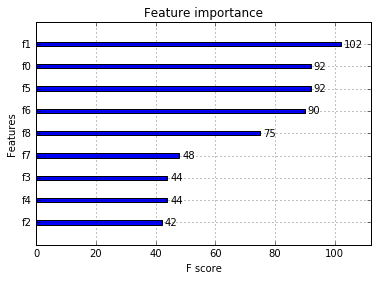

In [28]:
print(model.feature_importances_)

plot_importance(model)
plt.show()

The above results show the four most important feature responsible for the fail or success of the oligonucleotide synthesis:
  -  GC content (GC_norm)
  -  haripin percentage (hairpin_norm)
  -  length (length)
  -  bulge percentage (bulge_norm)

This is slightly different from the features correlated with the failed synthesis from the statistical analysis: 
  - length (length)
  - miminum free energy (mfe)
  - paired group
  - paired GC group
    
These difference comes from 1) correlation doesn't mean causation 2) our statistical analysis is based on absolute value while
our machine learning is based on normalized value. Here machine learning gave us more reliable results.
Let's plot the four features identified via machine learning using normalized data.

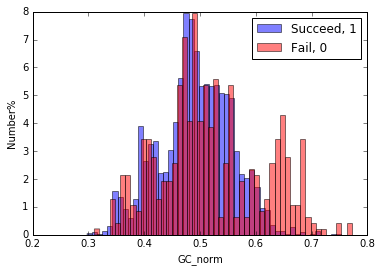

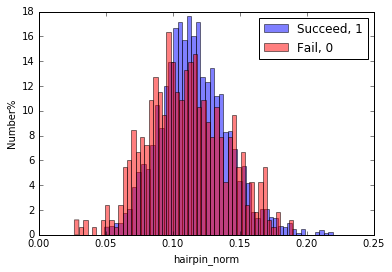

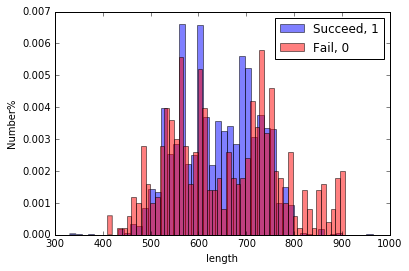

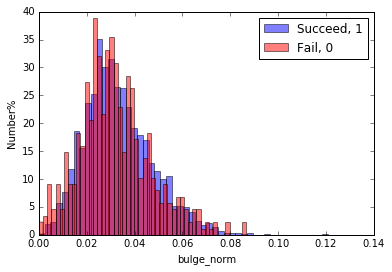

In [30]:
def plot_var_norm(name):
    plt.hist(train.loc[train.success == 1, name], bins = 50, color = 'b', normed = True, alpha = 0.5, log = False, 
             label = 'Succeed, 1')
    plt.hist(train.loc[train.success == 0, name], bins = 50, color = 'r', normed = True, alpha = 0.5, log = False,
             label = 'Fail, 0')
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Number%')
    plt.show()
    
# add the 'success' column
train['success'] = Y

plot_var_norm('GC_norm')
plot_var_norm('hairpin_norm')
plot_var_norm('length')
plot_var_norm('bulge_norm')

Conclusions drawn from the above histograph is:
Oligonucleotides with higher GC content, lower hairpin content, longer length are more likely to fail in the synthesis. The bulge percentage alone does not give indication on whether the synthesis is likely to fail or succeed. It probably works together with other features. We will ignore it now for simplicity.

### Summary

Here, we've build a XGBoost machine learning model which give us a prediction accuracy of 84.38% of the synthesis outcome (fail 
or success) for any input oligonucleotide. 

We figured out the three most important features responsible for the fail or success of the oligonucleotide synthesis are:
  -  GC content (GC_norm)
  -  haripin percentage (hairpin_norm)
  -  length (length)

Oligonucleotides with higher GC content, lower hairpin content, longer length ( ~ 820 is likely to be the threshold) are more 
likely to fail in the synthesis.

In order to increase the success rate of the oligonucleotide synthesis, the researchers need to try to:
    - 1) reduce the percentage of G, C bases, replace G, C with A, T bases if possible.
    - 2) slightly increase the hairpin content if possible
    - 3) decrease the length to below 820 base pair if possible. 